## 1. Configuració inicial i càrrega del fitxer GDF

Aquesta secció configura l'entorn per a la càrrega de dades EEG des d'un fitxer GDF. 
Inicialment, obtenim el directori actual de treball i, a continuació, construïm el camí absolut al fitxer GDF. 
Si el fitxer existeix, es carrega utilitzant la biblioteca MNE i es mostra la informació de les dades carregades.

In [612]:
import os
import mne

# Get the current working directory
current_directory = os.getcwd()

# Move up one directory to the parent directory
parent_directory = os.path.dirname(current_directory)

# Define the relative path to the GDF file
relative_gdf_file_path = 'dataset/B0101T.gdf'

# Build the absolute path to the GDF file
gdf_file_path = os.path.join(parent_directory, relative_gdf_file_path)

# Check if the file exists
if os.path.exists(gdf_file_path):
    # Load the data using MNE
    raw_data = mne.io.read_raw_gdf(gdf_file_path, preload=True)
    # Print the information about the channels
    raw_data.info
else:
    "GDF file not found or could not be loaded."

print(raw_data._raw_extras[0]['subject_info'])
print(raw_data._raw_extras[0]['subject_info']['sex'])
print(raw_data._raw_extras[0]['subject_info']['age'])
print(raw_data._raw_extras[0]['subject_info']['handedness'])
print(raw_data._raw_extras[0]['subject_info']['smoking'])


/var/folders/lt/rksts1mn7p7f78615mlf9g7h0000gn/T/ipykernel_8949/1716258113.py:19: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_gdf(gdf_file_path, preload=True)


{'id': 'B01', 'name': 'X', 'smoking': 'No', 'alcohol_abuse': 'Unknown', 'drug_abuse': 'Unknown', 'medication': 'Unknown', 'weight': None, 'height': None, 'sex': 'Female', 'handedness': 'Right', 'visual': 'Unknown', 'birthday': datetime.datetime(1984, 12, 1, 12, 0, tzinfo=datetime.timezone.utc), 'age': 39, 'headsize': array([1.e+20, 1.e+20, 1.e+20], dtype=float32)}
Female
39
Right
No


## 2. Extracció i visualització d'informació de canals i esdeveniments

Aquesta secció extreu i mostra la informació dels canals i els esdeveniments de les dades EEG. 
Incloent els noms dels canals, els tipus de canals i la informació dels esdeveniments anotats. 
Això proporciona una visió general dels components de les dades EEG abans de la seva anàlisi detallada.

In [613]:
# Extracting the channel names and types from the data
channel_info = raw_data.info['chs']
channel_names = [ch['ch_name'] for ch in channel_info]
channel_types = [ch['kind'] for ch in channel_info]

# Extracting event information
events, event_id = mne.events_from_annotations(raw_data)

# Displaying channel names, types, and event information
channel_names, channel_types, event_id

(['EEG:C3', 'EEG:Cz', 'EEG:C4', 'EOG:ch01', 'EOG:ch02', 'EOG:ch03'],
 [2 (FIFFV_EEG_CH),
  2 (FIFFV_EEG_CH),
  2 (FIFFV_EEG_CH),
  2 (FIFFV_EEG_CH),
  2 (FIFFV_EEG_CH),
  2 (FIFFV_EEG_CH)],
 {'1023': 1,
  '1077': 2,
  '1078': 3,
  '1079': 4,
  '1081': 5,
  '276': 6,
  '277': 7,
  '32766': 8,
  '768': 9,
  '769': 10,
  '770': 11})

## 3. Inspecció visual de les dades EEG i EOG

Aquí, realitzem una inspecció visual de les dades EEG i EOG. 
Es mostren segments curts de dades per a una avaluació ràpida de la seva qualitat i per identificar possibles artefactes. 
Aquesta anàlisi visual és un pas important abans del processament més detallat de les dades.

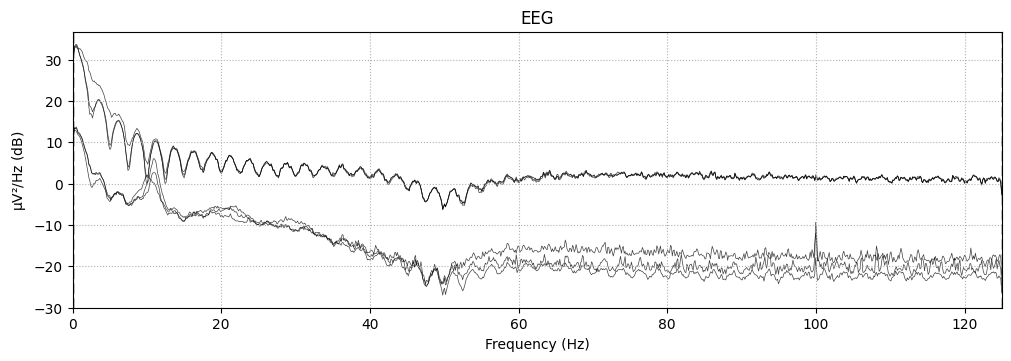

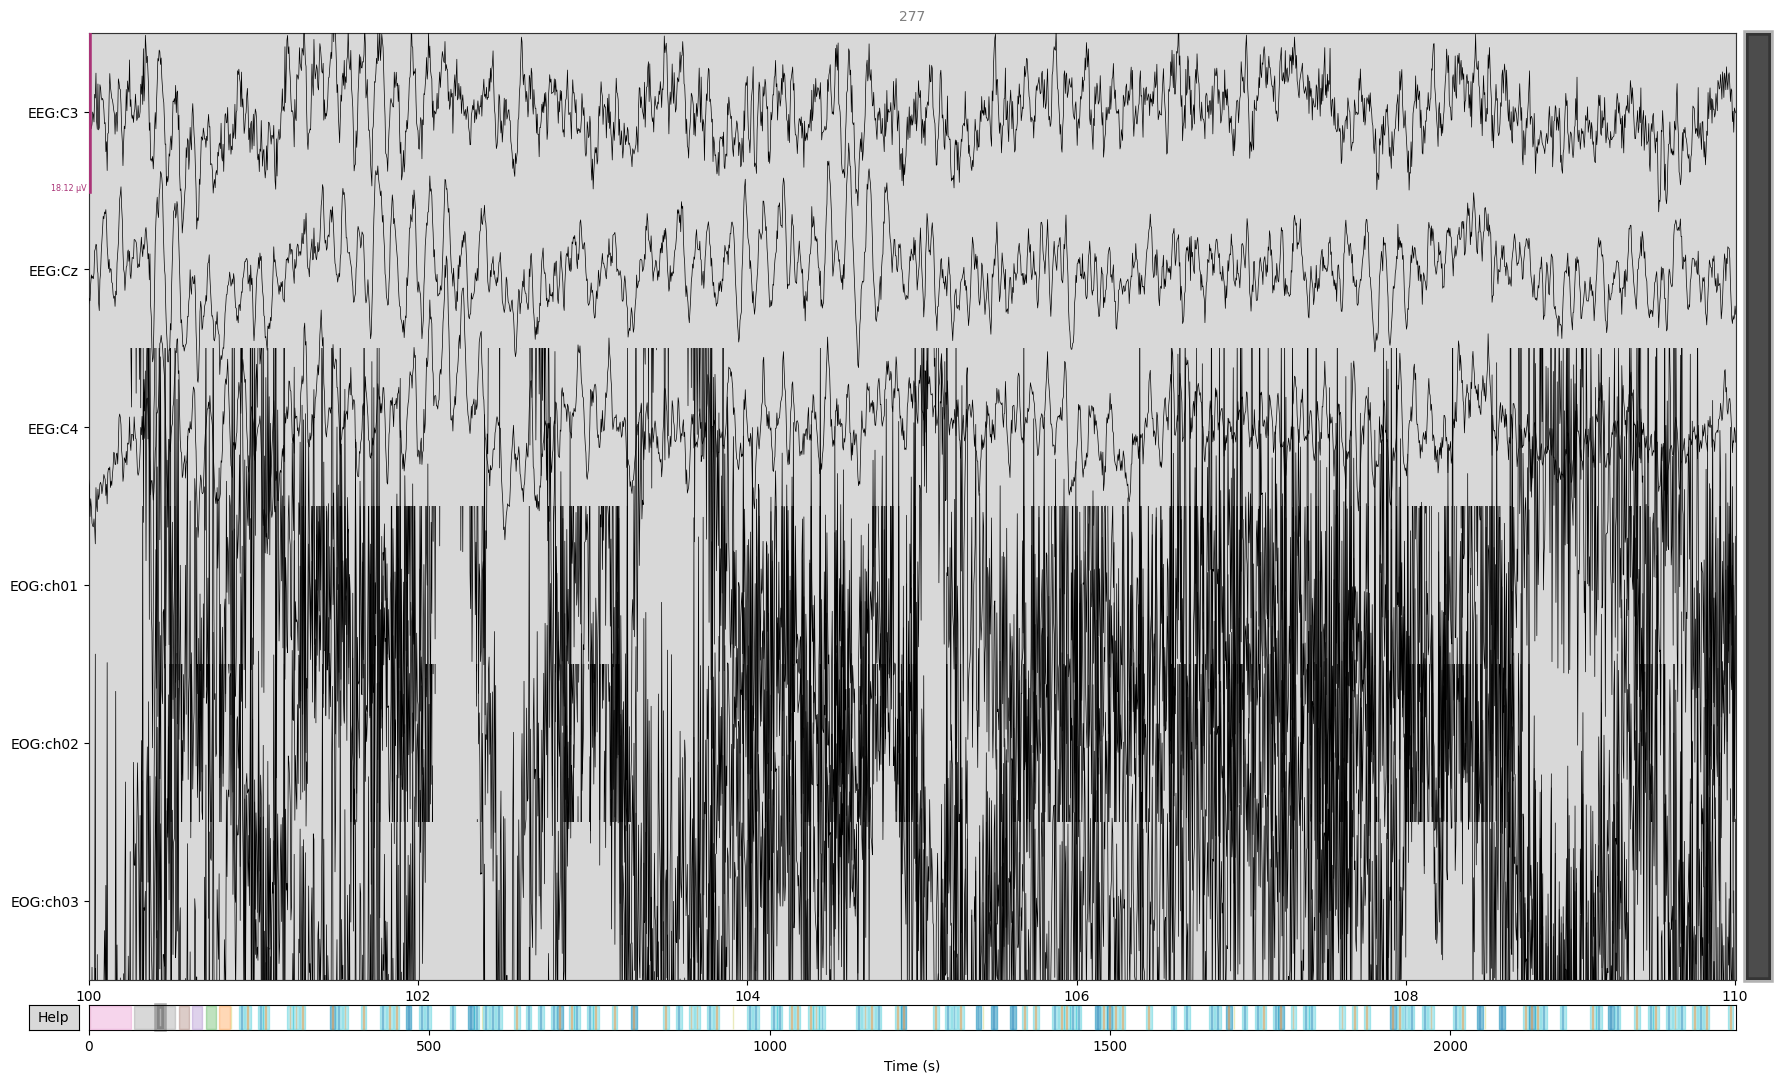

/var/folders/lt/rksts1mn7p7f78615mlf9g7h0000gn/T/ipykernel_8949/2698292099.py:21: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_data.compute_psd().plot()
/Users/superjordi/repos/uoc/TFG/BCI-Competition-IV-Experiments-data-set-B/venv-bci-experiment-1/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/var/folders/lt/rksts1mn7p7f78615mlf9g7h0000gn/T/ipykernel_8949/2698292099.py:27: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events, raw_data.info['sfreq'],


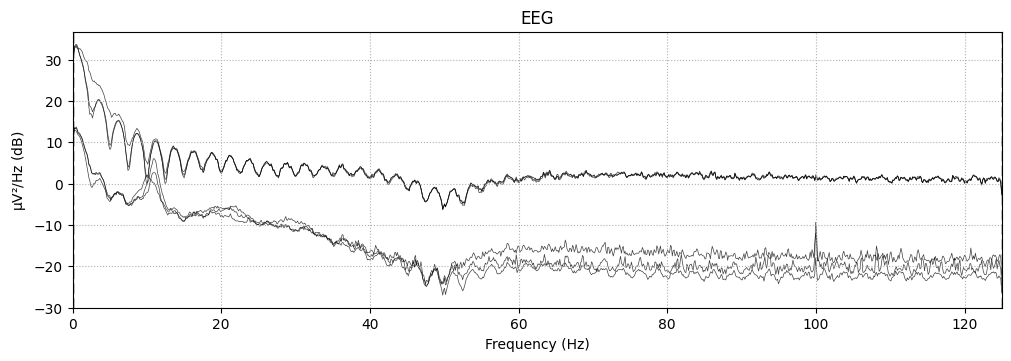

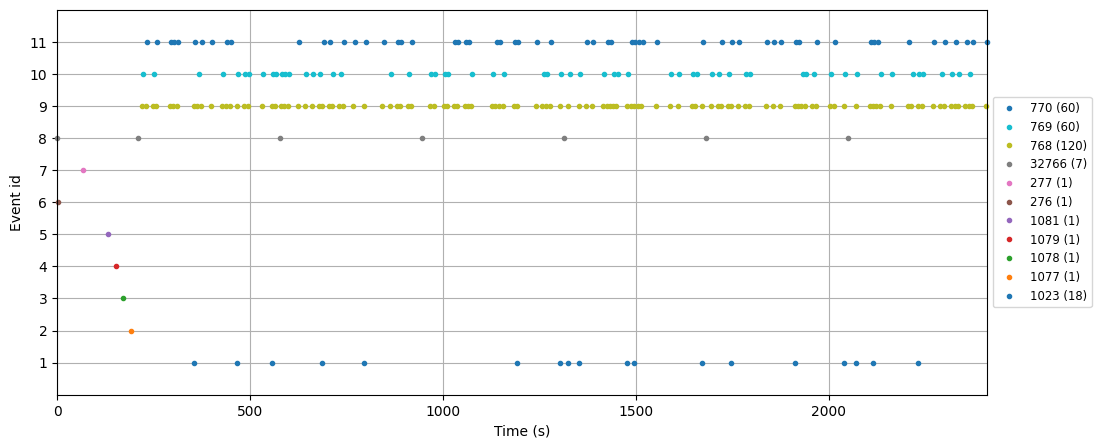

In [622]:
import matplotlib.pyplot as plt

# Plotting a short segment of the EEG and EOG data for visual inspection
plot_duration = 10  # in seconds
start_time = 100  # start time for the plot, in seconds

# Plot EEG data
raw_data.copy().pick('eeg').plot(start=start_time, duration=plot_duration, scalings='auto', title='EEG Data')

# Check if EOG channels are present and plot EOG data
channel_types = [mne.channel_type(raw_data.info, idx) for idx in range(raw_data.info['nchan'])]
if 'eog' in channel_types:
    raw_data.copy().pick('eog').plot(start=start_time, duration=plot_duration, scalings='auto', title='EOG Data')
else:
    "No EOG channels found."

# Plotting the EEG data with channel locations
plt.show()

# MNE’s .compute_psd() method calculates the power spectral density (PSD) of a data set. Power refers to the amplitude of sine waves when we are working in the frequency domain, spectrum means a range of frequencies, and density basically means we’re quantifying the power over a range of frequencies.
raw_data.compute_psd().plot()

# Aquí podem observar els dos pics a 50hz i 100hz degut a la freqüència de la corrent elèctrica (Europa) i els seus harmònics. TODO: @Fabio En el Paper (Data Recording, p2) diu que un notch filter de 50 Hz was enabled, malgrat a la gràfica els pics segueixen apareixent.

fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(events, raw_data.info['sfreq'],  
                    event_id=event_id,                    
                    axes=ax)
plt.show()

## 4. Creació d'epochs i inspecció visual de les mateixes

En aquesta secció, es creen epochs basades en esdeveniments de motor imagery i es realitza una inspecció visual d'unes quantes d'aquestes epochs. 
Les epochs són segments temporals de dades EEG al voltant d'esdeveniments específics, i la seva visualització ajuda a comprendre les dinàmiques temporals associades a diferents tipus d'activitat cerebral.

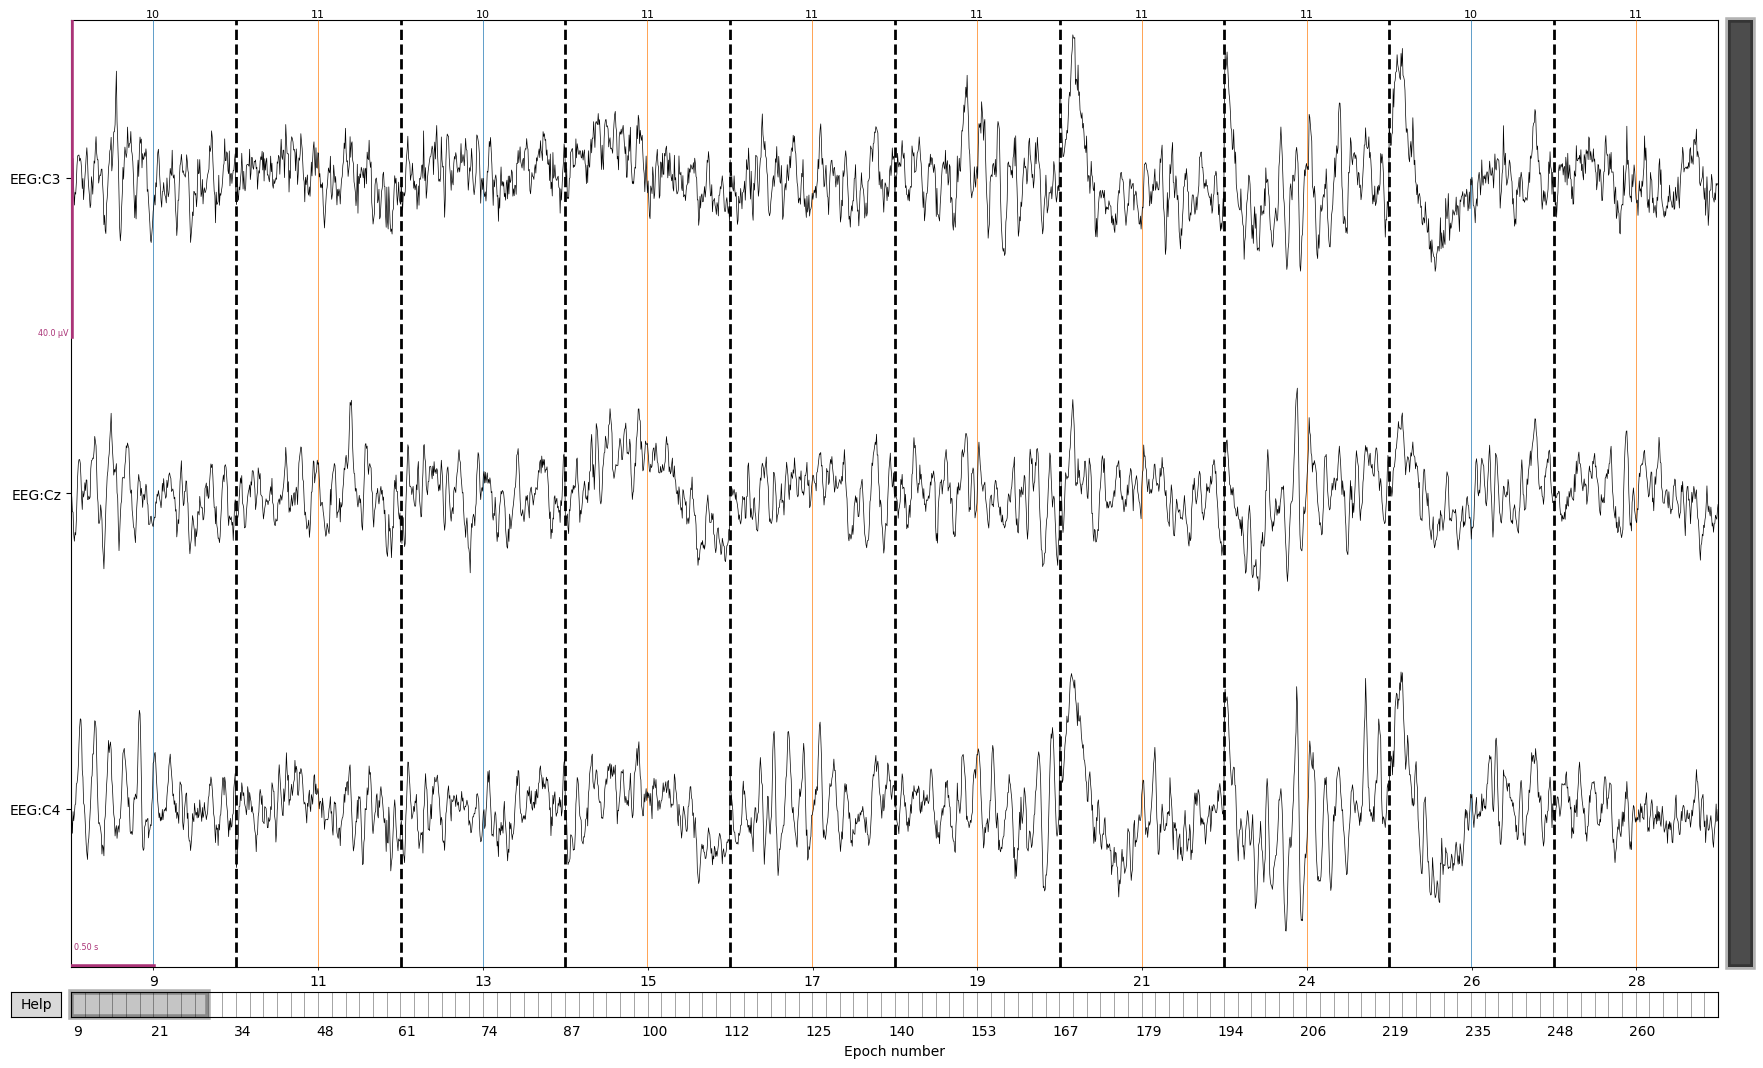

<Epochs |  120 events (all good), -0.5 – 0.5 s, baseline off, ~715 kB, data loaded,
 'Left Hand': 60
 'Right Hand': 60>
(120, 3, 251)


/var/folders/lt/rksts1mn7p7f78615mlf9g7h0000gn/T/ipykernel_8949/2284902830.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  epochs.plot(n_epochs=10, n_channels=len(picks), events=True).show()  # Plotting a few epochs for inspection)
/var/folders/lt/rksts1mn7p7f78615mlf9g7h0000gn/T/ipykernel_8949/2284902830.py:38: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  print(epochs.get_data().shape)


In [623]:
# Let's take a closer look at the events and their IDs
events_extracted = list(event_id.keys())
events_extracted.sort()

# Display the sorted list of extracted event descriptions and their corresponding IDs
events_extracted, [event_id[ev] for ev in events_extracted]

from mne import Epochs, pick_types

# Define the event IDs for left hand (class 1) and right hand (class 2) motor imagery
# We use the event IDs as they are represented in the data (10 for left hand, 11 for right hand)
event_id_motor_imagery = {'Left Hand': 10, 'Right Hand': 11}

# Define the time interval around the events for epoching (e.g., from -1 to 4 seconds)
tmin, tmax = -0.5, 0.5

# Noms dels canals EEG que vols incloure
eeg_channel_names = ['EEG:C3', 'EEG:Cz', 'EEG:C4']

# Seleccionar només aquests canals
picks = mne.pick_channels(raw_data.info['ch_names'], include=eeg_channel_names)

# Comprovar quins canals han estat seleccionats
selected_channels = [raw_data.info['ch_names'][i] for i in picks]
selected_channels

# Create epochs for motor imagery events
epochs = Epochs(raw_data, events, event_id_motor_imagery, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)

epochs.plot(n_epochs=10, n_channels=len(picks), events=True).show()  # Plotting a few epochs for inspection)

# Display the shape of the epochs array
print(epochs)

# obtenim 120 events, 60 left hand i 60 right hand, amb 3 canals EEG i 251 mostres per canal,
# les 251 mostres per canal corresponen a 1 segon de senyal, ja que la freqüència d'adquisició és de 250hz
# per tant, tenim 500ms abans de l'event i 500ms després de l'event, això ho podem visualitar aqui:
print(epochs.get_data().shape)

## 5. Filtratge de les epochs per a anàlisi específica de bandes de freqüència:

Aquesta secció aplica un filtre de banda passa a les èpoques per centrar-se en bandes de freqüència específiques que són rellevants per a l'anàlisi de tipus motor imagery. 
El filtratge ajuda a reduir el soroll i millora la claredat dels senyals per a anàlisis posteriors.

/var/folders/lt/rksts1mn7p7f78615mlf9g7h0000gn/T/ipykernel_8949/2884769115.py:5: RuntimeWarning: filter_length (413) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_epochs = epochs.copy().filter(low_freq, high_freq, fir_design='firwin')


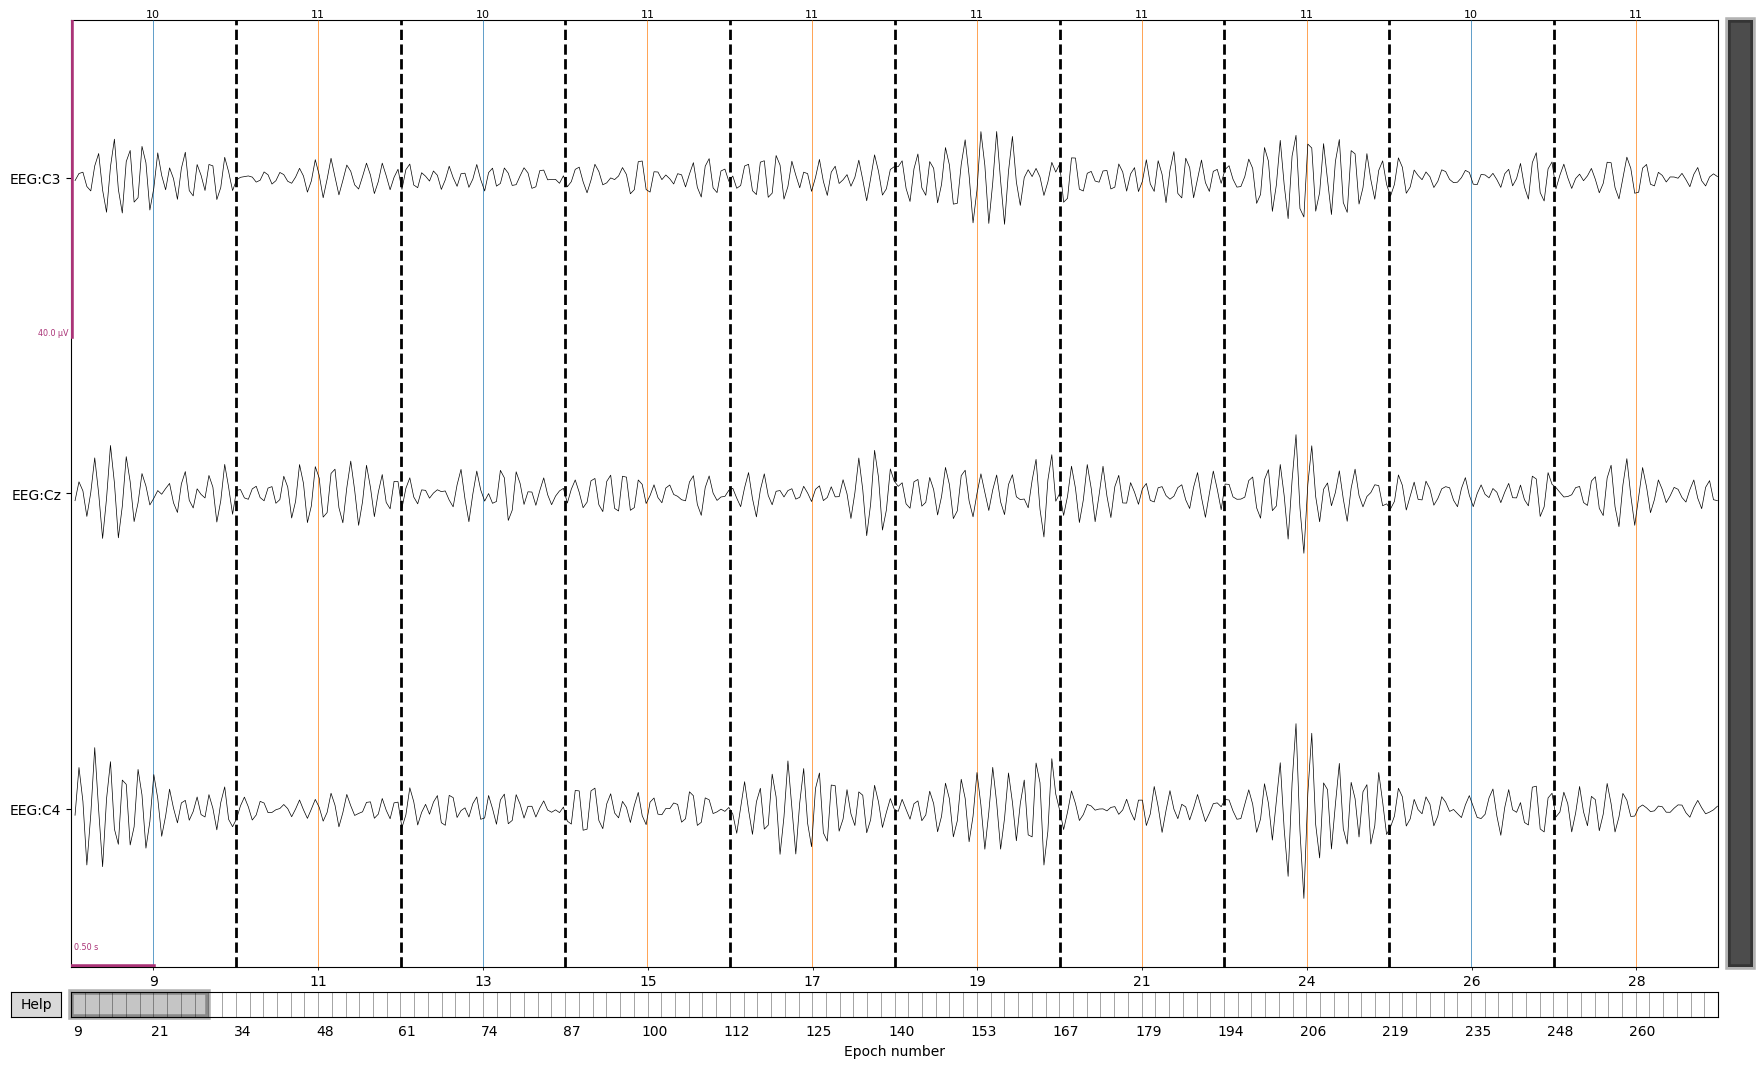

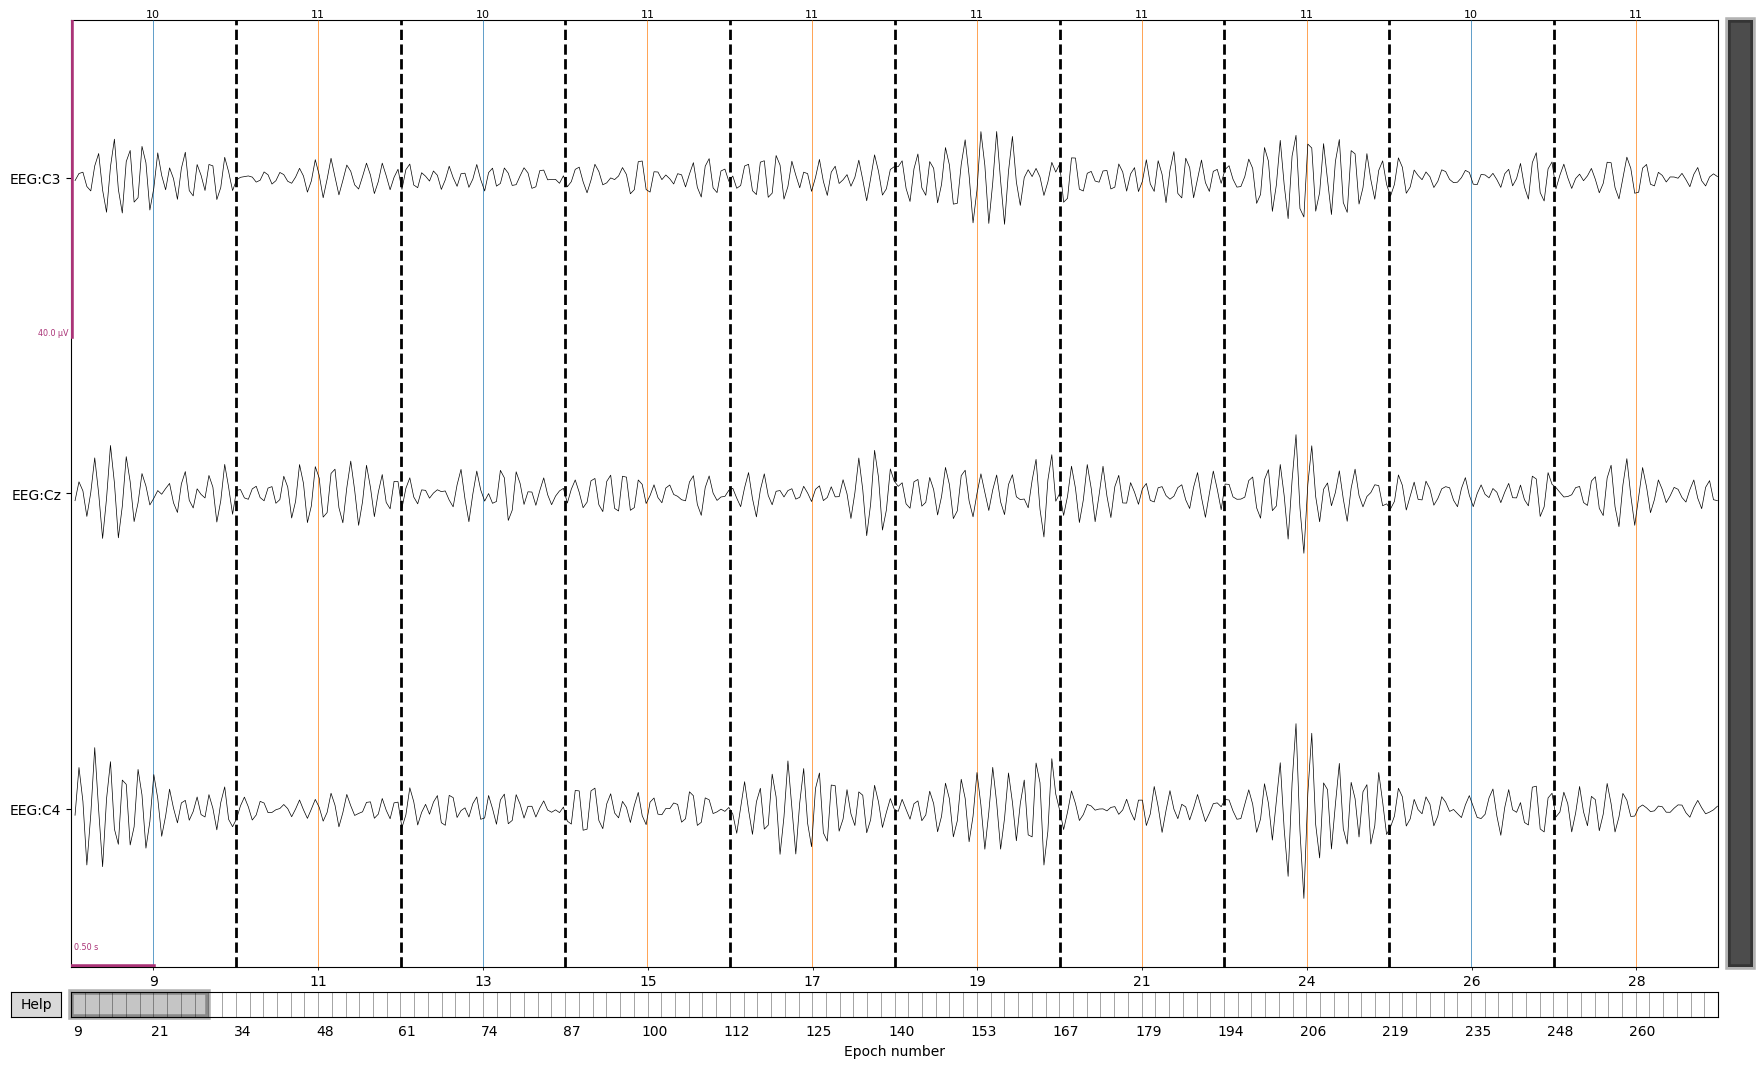

In [616]:
# Applying band-pass filter to the data
low_freq, high_freq = 8, 12  # Low and high cut-off frequencies

# Applying the filter to the EEG data
filtered_epochs = epochs.copy().filter(low_freq, high_freq, fir_design='firwin')

# Plotting the filtered data for a few epochs for visual inspection
filtered_epochs.plot(n_epochs=10, n_channels=len(picks), events=True)


## 6. Aplicació de l'Anàlisi de Components Independents (ICA)

L'ICA és utilitzada aquí per identificar i eliminar artefactes com parpelleigs o moviments musculars. 
Aquesta secció mostra com inicialitzar i ajustar ICA, i com visualitzar els components per a la identificació d'artefactes. 
És una tècnica clau en el preprocessament de dades EEG per a obtenir senyals més nets.

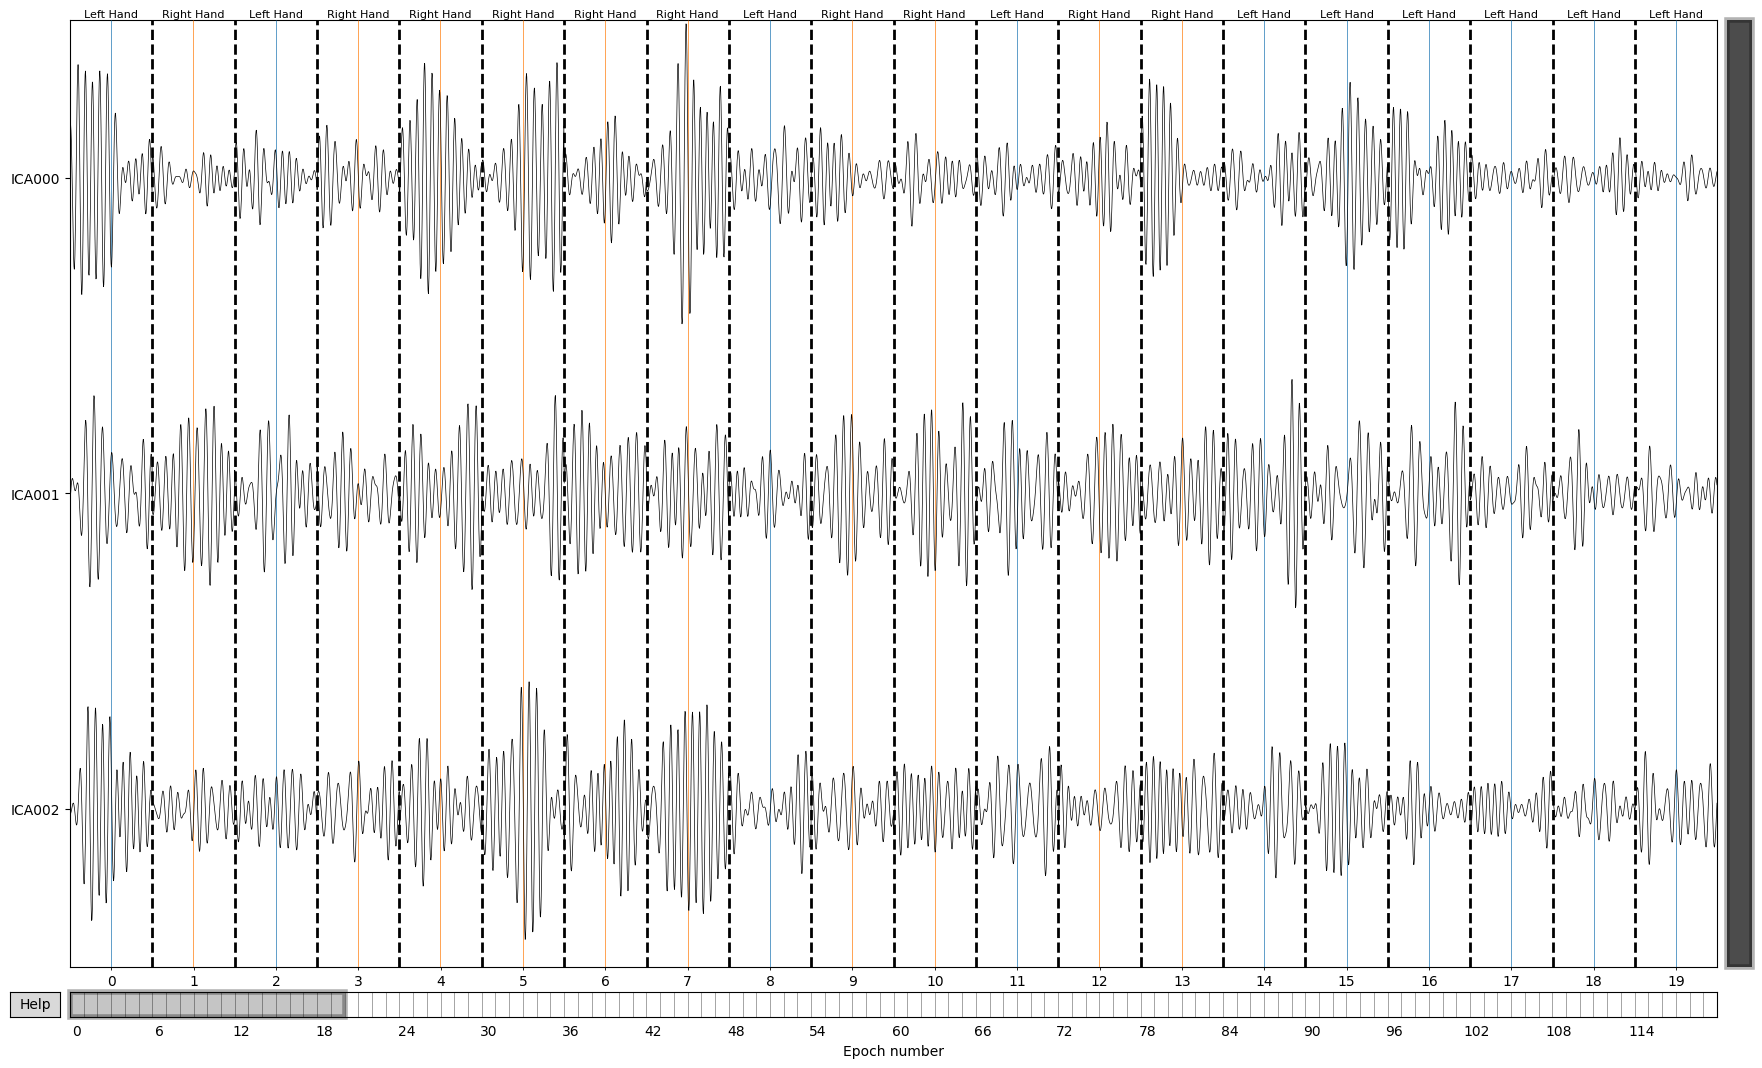

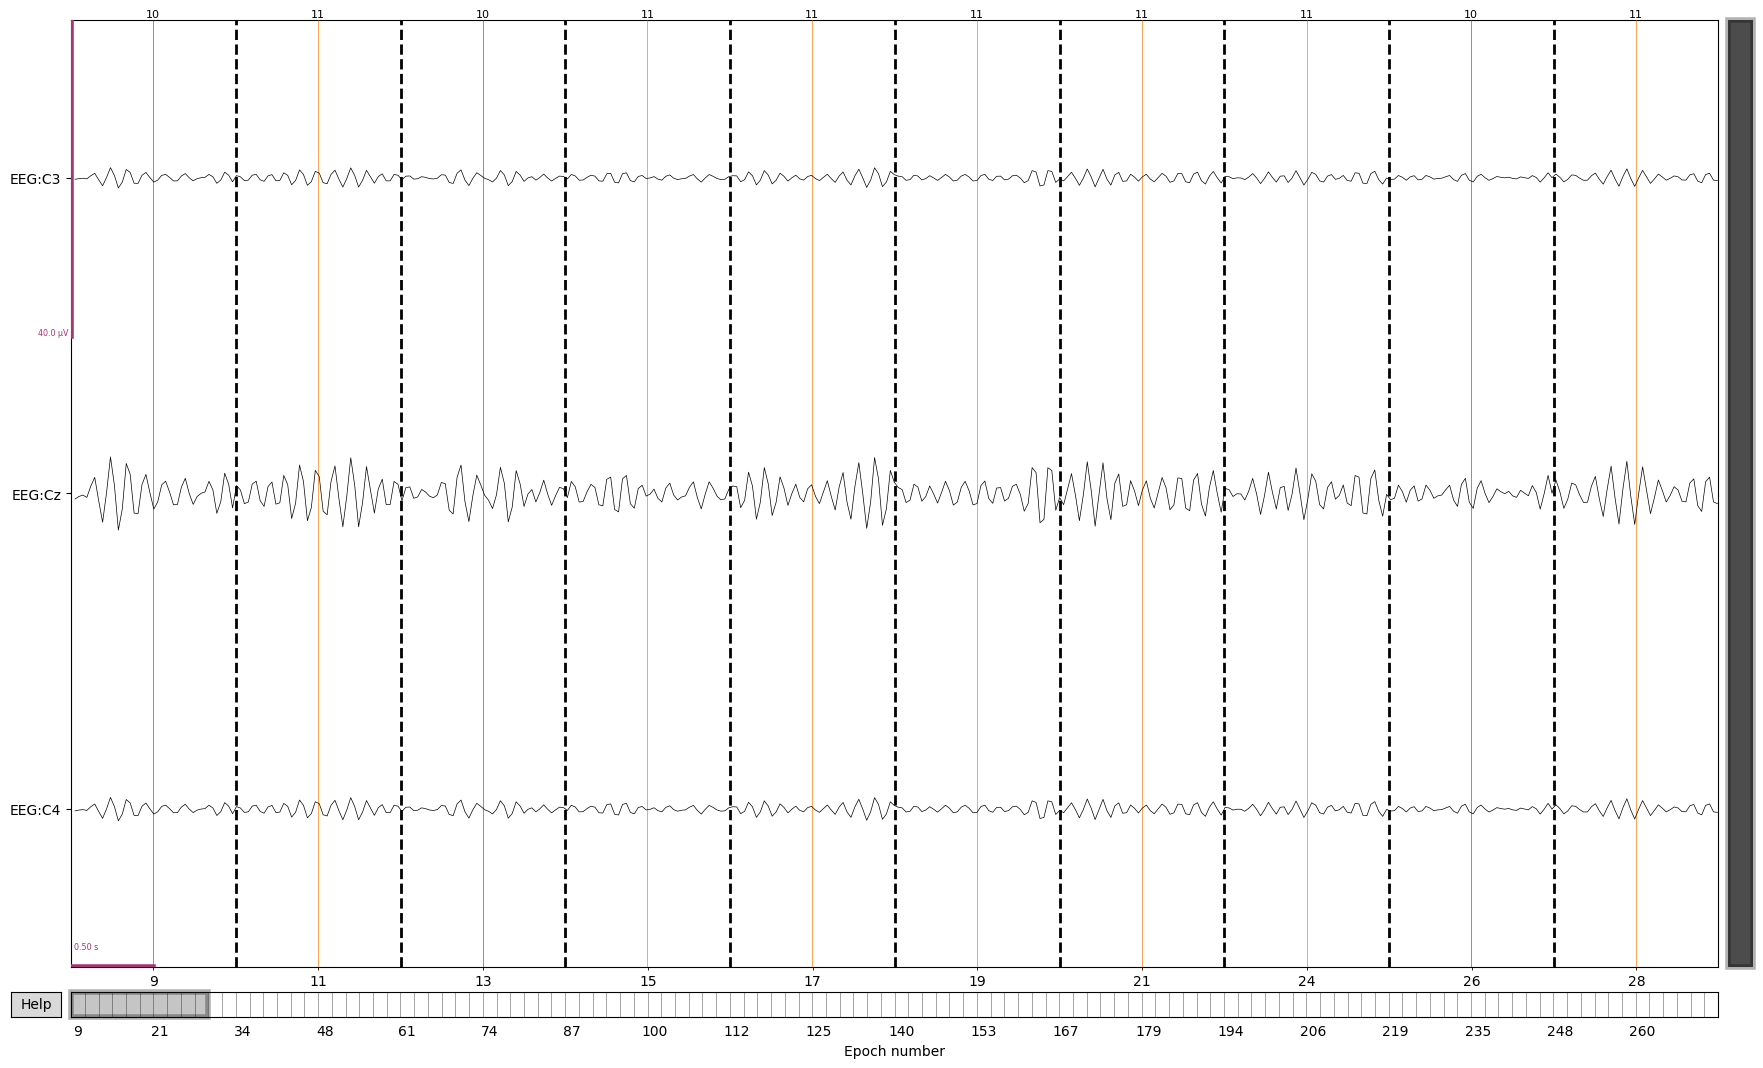

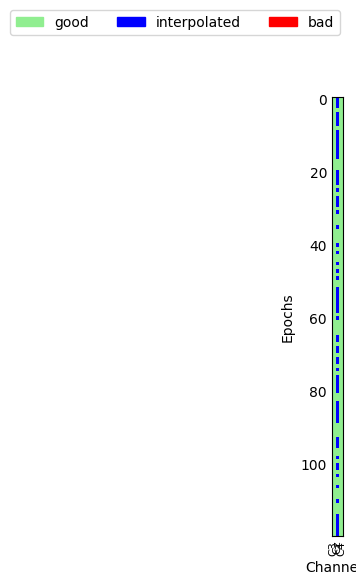

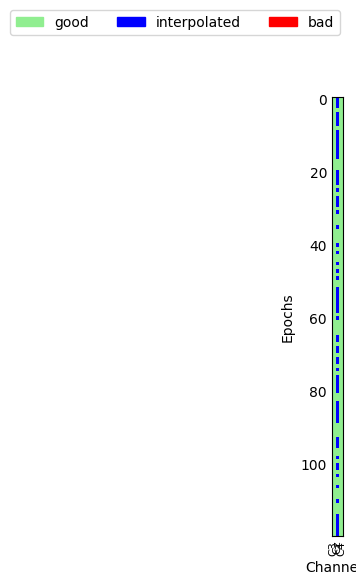

In [617]:

from mne.preprocessing import ICA

# Número de components per a ICA
n_components = len(filtered_epochs.ch_names)

# Inicialitza i ajusta ICA
ica = ICA(n_components=.99, random_state=42, max_iter=800) #https://neuraldatascience.io/7-eeg/erp_artifacts.html
ica.fit(filtered_epochs)

# Traça els components ICA (les fonts)
ica.plot_sources(filtered_epochs, show_scrollbars=True)

# Guarda el gràfic si és necessari
# ica.plot_sources(filtered_epochs).savefig('ica_sources_plot.png')
"""
from itertools import combinations

n_ica_components = len(ica.ch_names)

# Limit per al nombre de components a excloure en cada prova
max_excluded = 2

# Prepara els epochs originals per a la comparació
original_epochs = filtered_epochs.copy()

# Bucle per a provar totes les combinacions possibles
for n in range(max_excluded + 1):
    for components_to_exclude in combinations(range(n_ica_components), n):
        # Exclou els components seleccionats
        ica.exclude = list(components_to_exclude)

        # Aplica ICA als epochs filtrats
        cleaned_epochs = ica.apply(original_epochs.copy())

        # Visualitza els senyals nets
        print(f"Provant amb components exclosos: {components_to_exclude}")
        cleaned_epochs.plot(n_epochs=10, n_channels=len(original_epochs.ch_names))

#La combinació on s'elimina les components 0,1 es la que millors resultats dóna, per tant, la utilitzarem
"""

# Prepara els epochs originals per a la comparació
original_epochs = filtered_epochs.copy()

# Exclou els components seleccionats
ica.exclude = [0,2]

# Aplica ICA als epochs filtrats
cleaned_epochs = ica.apply(original_epochs.copy())

# Visualitza els senyals nets
cleaned_epochs.plot(n_epochs=10, n_channels=len(original_epochs.ch_names), events=True)

# Importar AutoReject
from autoreject import AutoReject

# Reanomenar els canals a noms estàndards
mappings = {'EEG:C3': 'C3', 'EEG:Cz': 'Cz', 'EEG:C4': 'C4'}
cleaned_epochs.rename_channels(mappings)

# Després, assignar un muntatge estàndard
montage = mne.channels.make_standard_montage('standard_1020')
cleaned_epochs.set_montage(montage)


# Definir el model AutoReject
ar = AutoReject(n_interpolate=[1, 2, 3, 4],
                random_state=42,
                picks=mne.pick_types(cleaned_epochs.info, eeg=True, eog=False),
                n_jobs=-1, 
                verbose=False)

# Ajustar AutoReject a les epochs netes
ar.fit(cleaned_epochs)

# Aplicar AutoReject per a obtenir epochs netejats i el registre de rebuig
epochs_ar, reject_log = ar.transform(cleaned_epochs, return_log=True)

# Opcional: Visualitzar el registre de rebuig per a veure quins epochs han estat afectats
reject_log.plot()

## 7. Extracció de característiques utilitzant la potència espectral

En aquesta secció, ens concentrem en l'extracció de característiques a partir de les bandes de freqüència alfa i beta. 
Utilitzem la potència espectral com a mètode d'extracció, que és crucial per a l'anàlisi de les dades de tipus motor imagery. 
Aquestes característiques seran utilitzades posteriorment per a la classificació.

In [618]:
import numpy as np

# Defineix les bandes de freqüència
freq_bands = {'alpha': (5, 17)
              #'beta': (13, 30)
              }

# Calcula la PSD per a tots els epochs
psd = epochs_ar.compute_psd(fmin=5, fmax=40, method='welch')
freqs = psd.freqs
psd_data = psd.get_data()

# Inicialitza una llista per emmagatzemar les característiques
features = []

# Itera sobre els psd_data (un array per cada epoch)
for psd_epoch in psd_data:
    # Inicialitza un diccionari per a les característiques d'aquest epoch
    epoch_features = {}

    # Calcula la potència mitjana en cada banda de freqüència
    for band, (fmin, fmax) in freq_bands.items():
        # Troba els índexs de freqüència dins de la banda
        freq_mask = (freqs >= fmin) & (freqs <= fmax)

        # Mitjana de la potència espectral dins de la banda
        mean_band_power = np.mean(psd_epoch[:, freq_mask], axis=1)
        epoch_features[band] = mean_band_power

    features.append(epoch_features)

# `features` ara conté les característiques de potència espectral per a cada epoch
features


[{'alpha': array([2.46834873e-14, 2.85397230e-14, 3.27603925e-14])},
 {'alpha': array([4.12645669e-14, 4.77112205e-14, 5.47671158e-14])},
 {'alpha': array([2.60778106e-14, 3.01518776e-14, 3.46109648e-14])},
 {'alpha': array([9.95170290e-15, 1.29362041e-13, 1.32080888e-14])},
 {'alpha': array([1.42338779e-14, 1.64575989e-14, 1.88914727e-14])},
 {'alpha': array([8.58226228e-15, 9.92304632e-15, 1.13905413e-14])},
 {'alpha': array([1.90835662e-14, 2.20649411e-14, 2.53280711e-14])},
 {'alpha': array([2.01264982e-14, 2.32708076e-14, 2.67122701e-14])},
 {'alpha': array([7.33832322e-15, 9.53907568e-14, 9.73956177e-15])},
 {'alpha': array([3.08601467e-14, 3.56813455e-14, 4.09581721e-14])},
 {'alpha': array([3.42712531e-14, 3.96253600e-14, 4.54854572e-14])},
 {'alpha': array([2.42099126e-14, 2.79921630e-14, 3.21318552e-14])},
 {'alpha': array([2.36662777e-14, 2.73635974e-14, 3.14103327e-14])},
 {'alpha': array([1.41751481e-14, 1.63896938e-14, 1.88135254e-14])},
 {'alpha': array([1.64673528e-14, 

## 8. Preparació de dades per a classificació amb SVM

Aquí, preparem les característiques i les etiquetes per a ser utilitzades en un model de classificació SVM. 
Això inclou la normalització de les característiques i la conversió de les etiquetes a un format adequat per al model. (Matricial)

In [619]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# `features` és la llista de característiques
# i `labels` és la llista d'etiquetes.

# Convertir les característiques en una matriu
X = np.array([feat['alpha'] for feat in features])
# test with alpha and beta
#X = np.array([np.concatenate((feat['alpha'], feat['beta'])) for feat in features])

# Extreure les etiquetes dels epochs
labels = epochs.events[:, -1]

# Mapejar els identificadors d'esdeveniments a etiquetes binàries (0 per a 'Left Hand', 1 per a 'Right Hand')
# Això depèn dels IDs d'esdeveniment específics que hem utilitzat per a 'Left Hand' i 'Right Hand'
label_map = {10: 0, 11: 1}
y = np.array([label_map[label] for label in labels])

# Dividir les dades en conjunts d'entrenament i prova
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalitzar les característiques de l'entrenament
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mostrar X_scaled
X_train_scaled
X_test_scaled

# Mostrar y
y

array([0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1])

## 9. Implementació i avaluació del classificador SVM

Finalment, implementem i avaluem un classificador SVM. 
Això inclou la divisió de les dades en conjunts d'entrenament i prova, l'entrenament del model, la realització de prediccions i l'avaluació de la seva precisió, mitjançant diverses mètriques com la matriu de confusió i l'informe de classificació. 
Aquesta secció culmina el flux de treball d'anàlisi de dades EEG.

In [620]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

# Crear el model SVM
svm_model = SVC(kernel='rbf')  # altres kernels: 'linear', 'poly', 'rbf', etc.

# Entrenar el model amb dades normalitzades
svm_model.fit(X_train_scaled, y_train)

# Fer prediccions amb les dades de prova
y_pred = svm_model.predict(X_test)

# Calcular mètriques d'avaluació
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
kappa_score = cohen_kappa_score(y_test, y_pred)

# Mostrar els resultats
print("Exactitud (Accuracy):", accuracy)
print("Matrís de Confusió:\n", conf_matrix)
print("Informe de Classificació:\n", class_report)
print("Puntuació Kappa:", kappa_score)


Exactitud (Accuracy): 0.625
Matrís de Confusió:
 [[ 0  9]
 [ 0 15]]
Informe de Classificació:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.62      1.00      0.77        15

    accuracy                           0.62        24
   macro avg       0.31      0.50      0.38        24
weighted avg       0.39      0.62      0.48        24

Puntuació Kappa: 0.0


/Users/superjordi/repos/uoc/TFG/BCI-Competition-IV-Experiments-data-set-B/venv-bci-experiment-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/superjordi/repos/uoc/TFG/BCI-Competition-IV-Experiments-data-set-B/venv-bci-experiment-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/superjordi/repos/uoc/TFG/BCI-Competition-IV-Experiments-data-set-B/venv-bci-experiment-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-sco